In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from torchvision import transforms as T
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
import numpy as np

# Define image augmentations for the training set
train_transforms = T.Compose([
    T.Resize((300, 300)),  # Resize to a fixed size
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),  # Random color jitter
    T.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    T.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    T.ToTensor(),  # Convert image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define the transformations for the validation and test sets (no augmentation)
val_transforms = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_transforms = val_transforms  # Same transformations for test data


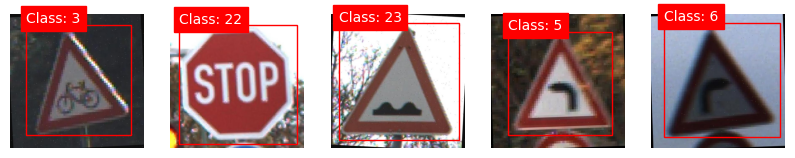

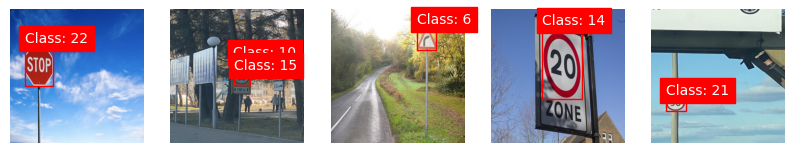

In [4]:
#8
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to plot random images with bounding boxes and labels
def plot_random_images_with_labels(image_dir, label_dir, num_images=5):
    img_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg') or img.endswith('.png')]
    selected_images = random.sample(img_paths, num_images)
    
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        
        # Load and overlay bounding box and label
        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                annotations = file.readlines()
                for annotation in annotations:
                    class_id, x_center, y_center, width, height = map(float, annotation.split())
                    plt.gca().add_patch(plt.Rectangle(
                        ((x_center - width / 2) * img.width, (y_center - height / 2) * img.height),
                        width * img.width,
                        height * img.height,
                        edgecolor='red',
                        facecolor='none'
                    ))
                    plt.text(
                        (x_center - width / 2) * img.width,
                        (y_center - height / 2) * img.height - 10,
                        f'Class: {int(class_id)}',
                        color='white',
                        backgroundcolor='red'
                    )
        plt.axis('off')
    plt.show()


# Directories for images and labels
train_img_dir = '/kaggle/input/roadsign/Road_Sign_Detection  3/train/images'  
train_label_dir = '/kaggle/input/roadsign/Road_Sign_Detection  3/train/labels'
val_img_dir = '/kaggle/input/roadsign/Road_Sign_Detection  3/valid/images'
val_label_dir = '/kaggle/input/roadsign/Road_Sign_Detection  3/valid/labels'

# Plot images with labels from train and validation sets
plot_random_images_with_labels(train_img_dir, train_label_dir)
plot_random_images_with_labels(val_img_dir, val_label_dir)



Step 9: Implement an Object Detection Model from Scratch 

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
import numpy as np

# Dataset class
class RoadSignDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg') or img.endswith('.png')]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = os.path.join(self.label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
        
        image = Image.open(img_path).convert("RGB")
        boxes = []
        labels = []
        
        with open(label_path, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split()
                labels.append(int(parts[0]))  # Class ID
                x_center, y_center, width, height = map(float, parts[1:])
                boxes.append([x_center, y_center, width, height])

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(boxes), torch.tensor(labels)

# Custom collate function to handle varying sizes of bounding boxes and filter empty samples
def collate_fn(batch):
    # Filter out samples with zero bounding boxes
    batch = [(img, box, label) for img, box, label in batch if box.size(0) > 0]

    if len(batch) == 0:
        return None  # Skip batch if all samples have zero bounding boxes

    images, boxes, labels = zip(*batch)

    # Stack images normally
    images = torch.stack(images, 0)

    # Determine max_boxes from the current batch to handle varying number of boxes
    max_boxes = max([box.size(0) for box in boxes])  # Find the max number of boxes in the batch
    
    if max_boxes == 0:
        return None  # Skip if there are no valid bounding boxes

    # Create padded tensors for boxes and labels
    padded_boxes = torch.zeros((len(boxes), max_boxes, 4))  # Create a padded tensor for boxes
    padded_labels = torch.zeros((len(labels), max_boxes), dtype=torch.long)  # Create a padded tensor for labels

    # Populate the padded tensors with the valid boxes and labels
    for i, (box, label) in enumerate(zip(boxes, labels)):
        if box.size(0) > 0:  # Only copy if there are valid boxes
            padded_boxes[i, :box.size(0), :] = box  # Pad each box
            padded_labels[i, :label.size(0)] = label  # Pad each label

    return images, padded_boxes, padded_labels


# Define transformations for training and validation
train_transforms = T.Compose([
    T.Resize((300, 300)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Initialize datasets and data loaders
train_dataset = RoadSignDataset(train_img_dir, train_label_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

val_dataset = RoadSignDataset(val_img_dir, val_label_dir, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

class SimpleObjectDetector(nn.Module):
    def __init__(self, nc, max_boxes=5):
        super(SimpleObjectDetector, self).__init__()
        self.nc = nc  # Number of classes
        self.max_boxes = max_boxes  # Maximum number of boxes per image
        
        # Convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Fully connected layers for bounding box and class predictions
        self.fc_bbox = nn.Linear(128 * 37 * 37, max_boxes * 4)   # Predict max_boxes bounding boxes per image
        self.fc_class = nn.Linear(128 * 37 * 37, max_boxes * nc) # Predict max_boxes class scores per image

    def forward(self, x):
        # Pass through convolutional layers
        x = self.features(x)
        
        # Flatten the feature map
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128 * 37 * 37)
        
        # Get bounding box predictions and reshape to (batch_size, max_boxes, 4)
        bbox = self.fc_bbox(x).view(-1, self.max_boxes, 4)
        
        # Get class scores and reshape to (batch_size, max_boxes, nc)
        class_scores = self.fc_class(x).view(-1, self.max_boxes, self.nc)
        
        return bbox, class_scores

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleObjectDetector(nc=25, max_boxes=5).to(device)
criterion_bbox = nn.MSELoss(reduction='none')  # Use reduction='none' to calculate element-wise loss
criterion_class = nn.CrossEntropyLoss(reduction='none')  # Use reduction='none' for masking
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
for epoch in range(10):  # Set desired number of epochs
    model.train()
    total_loss_bbox = 0
    total_loss_class = 0
    valid_boxes_count = 0
    
    for batch in train_loader:
        if batch is None:
            continue  # Skip empty batches

        images, boxes, labels = batch
        images, boxes, labels = images.to(device), boxes.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        pred_boxes, pred_classes = model(images)
        
        # Bounding Box Loss Calculation
        box_mask = (boxes.sum(dim=-1) != 0)  # Mask for non-padded boxes in target
        batch_loss_bbox = 0  # Initialize per-batch bounding box loss accumulator
        batch_loss_class = 0  # Initialize per-batch classification loss accumulator
        batch_valid_boxes = 0  # Counter for valid boxes per batch

        # Loop over each image in the batch
        for i in range(len(images)):
            num_valid_boxes = box_mask[i].sum().item()  # Count of valid boxes for this image
            if num_valid_boxes == 0:
                continue  # Skip if no valid boxes

            # Select only valid boxes for this image
            pred_boxes_valid = pred_boxes[i, :num_valid_boxes]
            boxes_valid = boxes[i, :num_valid_boxes]
            
            # Compute bounding box loss for the valid boxes in this image
            loss_bbox = criterion_bbox(pred_boxes_valid, boxes_valid).mean()
            batch_loss_bbox += loss_bbox
            batch_valid_boxes += num_valid_boxes

            # Select only valid class predictions and labels for this image
            pred_classes_valid = pred_classes[i, :num_valid_boxes]  # Shape: [num_valid_boxes, nc]
            labels_valid = labels[i, :num_valid_boxes]  # Shape: [num_valid_boxes]

            # Compute classification loss for the valid boxes in this image
            loss_class = criterion_class(pred_classes_valid, labels_valid).mean()  # Use mean() to get a single scalar
            batch_loss_class += loss_class

        # Average bounding box and classification loss over the valid images in this batch
        final_loss_bbox = batch_loss_bbox / batch_valid_boxes if batch_valid_boxes > 0 else 0
        final_loss_class = batch_loss_class / batch_valid_boxes if batch_valid_boxes > 0 else 0

        # Combine the final bounding box and classification losses
        total_loss = final_loss_bbox + final_loss_class
        total_loss.backward()
        optimizer.step()
        
        # Accumulate losses for reporting
        total_loss_bbox += final_loss_bbox.item()
        total_loss_class += final_loss_class.item()
        valid_boxes_count += batch_valid_boxes
    
    # Print loss for each epoch
    print(f"Epoch [{epoch+1}/10], Total Loss: {total_loss.item()}, BBox Loss: {total_loss_bbox / valid_boxes_count if valid_boxes_count > 0 else 0}, Class Loss: {total_loss_class}")


Epoch [1/10], Total Loss: 1.3189961910247803, BBox Loss: 0.028572917621697672, Class Loss: 1379.567397415638
Epoch [2/10], Total Loss: 0.9066784977912903, BBox Loss: 0.005756911188027659, Class Loss: 848.8542064130306
Epoch [3/10], Total Loss: 1.9091145992279053, BBox Loss: 0.007112922286369506, Class Loss: 626.6246920749545
Epoch [4/10], Total Loss: 0.4883304834365845, BBox Loss: 0.007532223156934353, Class Loss: 489.75359273701906
Epoch [5/10], Total Loss: 2.080256938934326, BBox Loss: 0.008198724670841605, Class Loss: 397.6361943408847
Epoch [6/10], Total Loss: 0.7111340761184692, BBox Loss: 0.009142160774163055, Class Loss: 316.65055235940963
Epoch [7/10], Total Loss: 0.815610945224762, BBox Loss: 0.009600501059588856, Class Loss: 260.2921566248406
Epoch [8/10], Total Loss: 0.94951331615448, BBox Loss: 0.010050518687693941, Class Loss: 221.94126314204186
Epoch [9/10], Total Loss: 0.2943675220012665, BBox Loss: 0.010527645302915412, Class Loss: 203.2729850022588
Epoch [10/10], Total

Code for IoU Calculation and Visualization

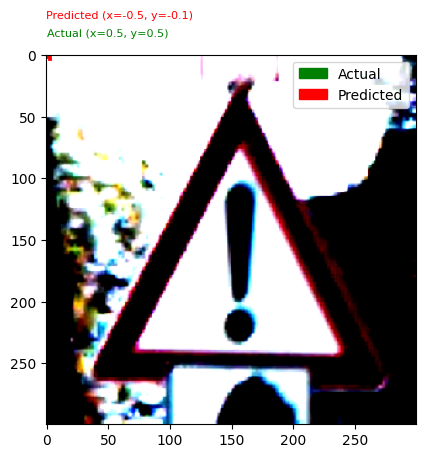

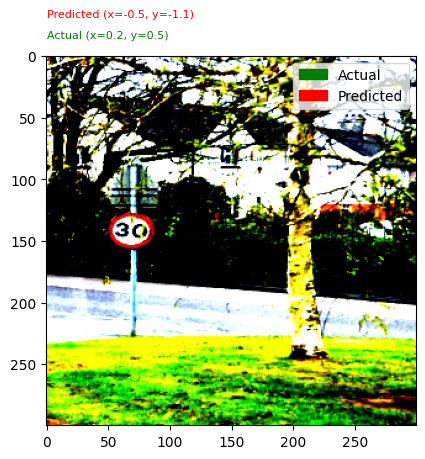

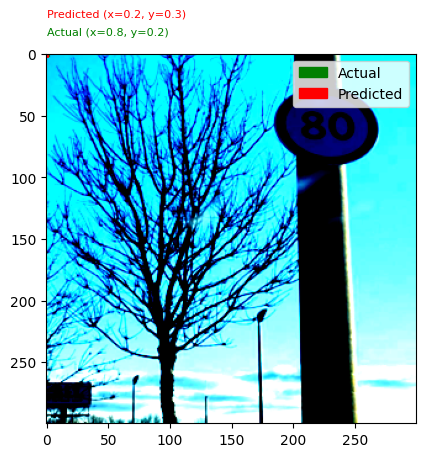

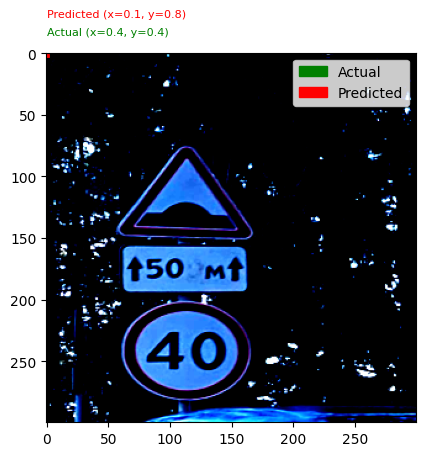

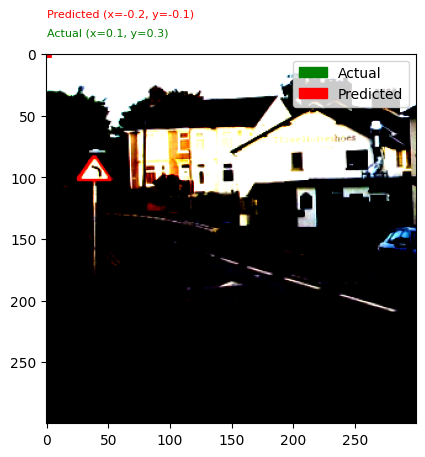

Average IoU: 0.1008


In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# IoU calculation function
def calculate_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    Each box is defined as [x_center, y_center, width, height].
    """
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    # Compute intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    
    # Union Area
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    # IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

# Function to calculate IoU and visualize predictions vs actual data
def visualize_predictions(val_loader, model, device, num_images=5):
    model.eval()
    iou_scores = []
    images_displayed = 0  # Counter to display only num_images

    # Use the validation loader as test data
    for images, boxes, labels in val_loader:
        images = images.to(device)
        
        with torch.no_grad():
            pred_boxes, _ = model(images)
        
        for i in range(len(images)):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            true_boxes = boxes[i]
            predicted_boxes = pred_boxes[i]
            
            # Calculate IoU for each true-predicted box pair
            for true_box, pred_box in zip(true_boxes, predicted_boxes):
                if true_box.sum() == 0:  # Skip padding
                    continue
                iou = calculate_iou(pred_box.cpu().numpy(), true_box.cpu().numpy())
                iou_scores.append(iou)
            
            # Visualization of predictions vs. actual boxes with enhanced clarity
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            
            # Plot true bounding boxes in green with "Actual" label
            for true_box in true_boxes:
                if true_box.sum() == 0:
                    continue
                true_box = true_box.cpu().numpy()
                rect = patches.Rectangle(
                    (true_box[0] - true_box[2] / 2, true_box[1] - true_box[3] / 2),
                    true_box[2], true_box[3], linewidth=3, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
                ax.text(true_box[0] - true_box[2] / 2, true_box[1] - true_box[3] / 2 - 15,
                        f"Actual (x={true_box[0]:.1f}, y={true_box[1]:.1f})", color="green", fontsize=8, backgroundcolor="white")

            # Plot predicted bounding boxes in red with "Predicted" label
            for pred_box in predicted_boxes:
                pred_box = pred_box.cpu().numpy()
                rect = patches.Rectangle(
                    (pred_box[0] - pred_box[2] / 2, pred_box[1] - pred_box[3] / 2),
                    pred_box[2], pred_box[3], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(pred_box[0] - pred_box[2] / 2, pred_box[1] - pred_box[3] / 2 - 30,
                        f"Predicted (x={pred_box[0]:.1f}, y={pred_box[1]:.1f})", color="red", fontsize=8, backgroundcolor="white")
            
            # Legend for clarity
            plt.legend(handles=[patches.Patch(color='green', label='Actual'), patches.Patch(color='red', label='Predicted')])
            plt.show()
            
            # Increment the displayed images counter
            images_displayed += 1
            if images_displayed >= num_images:
                break
        if images_displayed >= num_images:
            break

    # Display average IoU score
    if len(iou_scores) > 0:
        print(f"Average IoU: {sum(iou_scores) / len(iou_scores):.4f}")
    else:
        print("No valid bounding boxes to compute IoU.")

# Call the function with validation loader, model, and device
visualize_predictions(val_loader, model, device, num_images=5)


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# Define a function to calculate the Intersection over Union (IOU)
def calculate_iou(box1, box2):
    # box format: [x_center, y_center, width, height] -> convert to [x_min, y_min, x_max, y_max]
    box1_x1, box1_y1 = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
    box1_x2, box1_y2 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
    box2_x1, box2_y1 = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
    box2_x2, box2_y2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # Calculate intersection
    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Calculate union
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    # Compute IOU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

Average IOU across test set: 0.6206


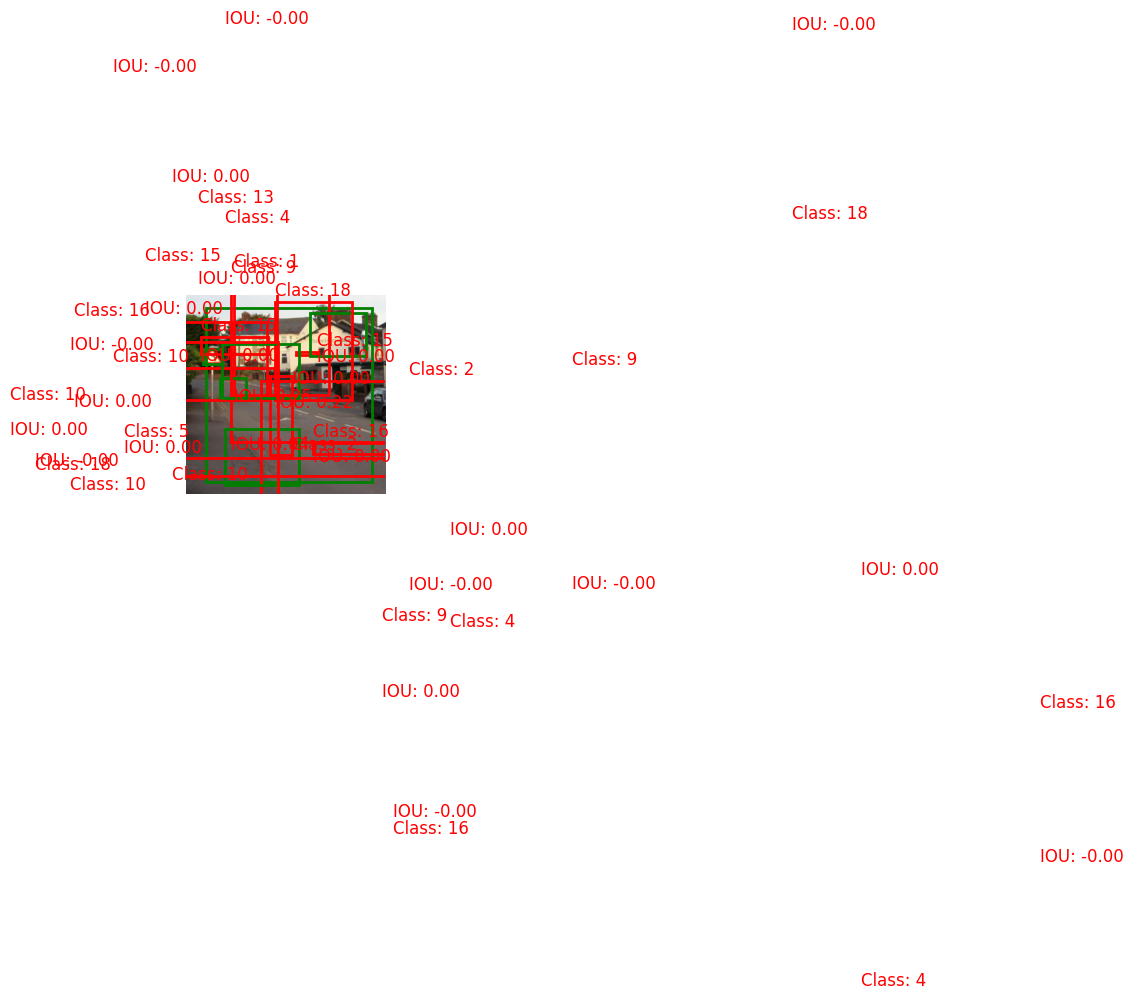

In [14]:



def evaluate_and_plot_predictions(model, test_loader, threshold=0.5, num_images=5):
    model.eval()
    plt.figure(figsize=(15, 15))

    total_iou = 0
    total_boxes = 0
    
    with torch.no_grad():
        for i, (images, true_boxes, true_labels) in enumerate(test_loader):
            if i >= num_images:
                break
            images = images.to(device)
            pred_boxes, pred_classes = model(images)
            pred_boxes = pred_boxes.cpu()
            pred_classes = pred_classes.cpu()

            for j in range(len(images)):
                img = images[j].cpu().permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                plt.subplot(num_images, 1, j + 1)
                plt.imshow(img)
                plt.axis('off')
                
                # Plot true bounding boxes
                for box in true_boxes[j]:
                    box = box.numpy()
                    x_min = (box[0] - box[2] / 2) * img.shape[1]
                    y_min = (box[1] - box[3] / 2) * img.shape[0]
                    width = box[2] * img.shape[1]
                    height = box[3] * img.shape[0]
                    plt.gca().add_patch(plt.Rectangle((x_min, y_min), width, height, edgecolor='green', facecolor='none', lw=2))

                # Plot predicted bounding boxes and compute IOU
                for k in range(pred_boxes.shape[1]):
                    pred_box = pred_boxes[j, k].numpy()
                    pred_class = pred_classes[j, k].argmax().item()
                    if pred_class != 0:  # Assuming class 0 is background
                        x_min = (pred_box[0] - pred_box[2] / 2) * img.shape[1]
                        y_min = (pred_box[1] - pred_box[3] / 2) * img.shape[0]
                        width = pred_box[2] * img.shape[1]
                        height = pred_box[3] * img.shape[0]
                        plt.gca().add_patch(plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', lw=2))
                        plt.text(x_min, y_min - 10, f'Class: {pred_class}', color='red', fontsize=12)

                        # Calculate IOU with ground truth boxes
                        iou_scores = [calculate_iou(pred_box, true_box) for true_box in true_boxes[j].numpy()]
                        max_iou = max(iou_scores)
                        total_iou += max_iou  # Accumulate IOU
                        total_boxes += 1      # Count boxes
                        plt.text(x_min, y_min + height + 10, f'IOU: {max_iou:.2f}', color='red', fontsize=12)

    # Calculate and print average IOU after the evaluation loop
    avg_iou = total_iou / total_boxes if total_boxes > 0 else 0
    print(f"Average IOU across test set: {avg_iou:.4f}")

test_img_dir = '/kaggle/input/roadsign/Road_Sign_Detection  3/test'
# Load test dataset and run evaluation
test_dataset = RoadSignDataset(val_img_dir, val_label_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Run evaluation and plot
evaluate_and_plot_predictions(model, test_loader)
plt.show()

